In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pymongo as pm
import numpy as np

x = np.linspace(-2, 2, 101)[np.random.RandomState(0).permutation(101)]
y = x ** 3 - 1

### 1.) Insert x and y into the database "tasks", collection "polyfunction" on host "localhost", port "24444", read it out again in sorted order print "x" and plot "y"

In [5]:
port = 24444
host = 'localhost'
connection = pm.MongoClient(port = port, host = host)

entries = []
for i in range(101):
    entries.append({'x': x[i], 'y': y[i]})
connection['tasks']['polyfunction'].insert_many(entries)

[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -1.96, -1.96, -1.96, -1.96, -1.96, -1.96, -1.92, -1.92, -1.92, -1.92, -1.92, -1.92, -1.88, -1.88, -1.88, -1.88, -1.88, -1.88, -1.84, -1.84, -1.84, -1.84, -1.84, -1.84, -1.8, -1.8, -1.8, -1.8, -1.8, -1.8, -1.76, -1.76, -1.76, -1.76, -1.76, -1.76, -1.72, -1.72, -1.72, -1.72, -1.72, -1.72, -1.68, -1.68, -1.68, -1.68, -1.68, -1.68, -1.6400000000000001, -1.6400000000000001, -1.6400000000000001, -1.6400000000000001, -1.6400000000000001, -1.6400000000000001, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.56, -1.56, -1.56, -1.56, -1.56, -1.56, -1.52, -1.52, -1.52, -1.52, -1.52, -1.52, -1.48, -1.48, -1.48, -1.48, -1.48, -1.48, -1.44, -1.44, -1.44, -1.44, -1.44, -1.44, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.3599999999999999, -1.3599999999999999, -1.3599999999999999, -1.3599999999999999, -1.3599999999999999, -1.3599999999999999, -1.3199999999999998, -1.3199999999999998, -1.3199999999999998, -1.3199999999999998, -1.3199999999999998, -1.3199999999999998, -1.28, -1.28, -

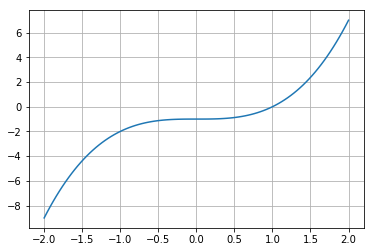

In [6]:
entries = connection['tasks']['polyfunction'].find({'x': {'$exists' : True}}, projection=['x', 'y']).sort([('x',pm.ASCENDING)])
x = [entry['x'] for entry in entries]
print(x)
entries = connection['tasks']['polyfunction'].find({'x': {'$exists' : True}}, projection=['x', 'y']).sort([('x',pm.ASCENDING)])
y = [entry['y'] for entry in entries]
plt.plot(x,y)
plt.grid()

### 2.) Run the script below which trains a MLP for the 10-way MNIST classification task 

In [7]:
import tensorflow as tf
from __future__ import division
from tfutils import base, data, optimizer, utils

# delete exp1
connection['mnist']['simple.files'].delete_many({'exp_id' : 'exp1'})

def mnist_model(inputs, train=True, **kwargs):
    # trainable variables randomly initialized
    with tf.variable_scope("mnist"):
        W1 = tf.get_variable('W1', [784,128], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b1 = tf.get_variable('b1', [128], tf.float32, tf.random_normal_initializer(stddev=0.1))
        W2 = tf.get_variable('W2', [128,32], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b2 = tf.get_variable('b2', [32], tf.float32, tf.random_normal_initializer(stddev=0.1))
        W3 = tf.get_variable('W3', [32,10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b3 = tf.get_variable('b3', [10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        
        # hidden layers
        h1 = tf.nn.sigmoid(tf.matmul(inputs['images'], W1) + b1, name='hidden1')
        h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2, name='hidden2')
        # output
        output = tf.matmul(h2, W3) + b3

    return output, {}

params = {}

params['load_params'] = {
    'do_restore': False}

params['save_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'save_valid_freq': 200,
    'save_filters_freq': 100,
    'cache_filters_freq': 100}

params['train_params'] = {
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'num_steps': 100}

params['model_params'] = {
    'func': mnist_model} 

params['learning_rate_params'] = {
    'learning_rate': 0.5,
    'decay_steps': 500,
    'decay_rate': 0.95,
    'staircase': True}

params['optimizer_params'] = {
    'func': optimizer.ClipOptimizer,
    'optimizer_class': tf.train.MomentumOptimizer,
    'momentum': 0.9,
    'clip': True,
}

params['loss_params'] = {
    'targets': ['labels'],
    'loss_per_case_func': tf.nn.sparse_softmax_cross_entropy_with_logits,
    'agg_func': tf.reduce_mean
}

params['skip_check'] = True

base.train_from_params(**params)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:thres_loss not specified for model 0... Defaulting thres_loss to: 100.
INFO:tfutils:train_loop not specified for model 0... Using default training loop.
INFO:tfutils:validate_fist not specified for model 0... Defaulting validate_first to: True.
INFO:tfutils:minibatch_size not specified for training data_params... Defaulting minibatch_size to: 256 (identical to the batch size).


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.


Instructions for updating:
fn1/fn2 are deprecated in favor of the true_fn/false_fn arguments.
INFO:tfutils:Initialized from scratch first
INFO:tfutils:Training beginning ...
INFO:tfutils:Saving model with path prefix /home/dan/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:... done saving with path prefix /home/dan/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-0
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7f8238e308d0> database
INFO:tfutils:... done putting filters into database.
INFO:tfutils:Step 1 (217 ms) -- loss: 2.3540, learning_rate: 0.5000
INFO:tfutils:Step 2 (4 ms) -- loss: 2.3187, learning_rate: 0.5000
INFO:tfutils:Step 3 (5 ms) -- loss: 2.3153, learning_rate: 0.5000
INFO:tfutils:Step 4 (4 ms) -- loss: 2.3622, learning_rate: 0.5000
INFO:tfutils:Step 5 (4 ms) -- loss: 2.3368, learning_rate: 0.5000
INFO:tfutils:Step 6 (4 ms) -- loss: 2.2913, learning_rate: 0.5000
INFO:tfutils:Step 7 (4 ms) -- loss: 2.2774, learning_rate: 0.5000
I

mnist/b2/Momentum
global_step
mnist/W1/Momentum
Variable_5
mnist/b3/Momentum
mnist/W3/Momentum
mnist/b1
mnist/b2
mnist/b3
Variable_3
Variable_2
Variable_1
mnist/W2/Momentum
Variable
Variable_4
mnist/b1/Momentum
mnist/W3
mnist/W2
mnist/W1


INFO:tfutils:Saving model with path prefix /home/dan/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:... done saving with path prefix /home/dan/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-100
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7f8238e308d0> database
INFO:tfutils:... done putting filters into database.


[[ObjectId('59deb64ad4fdab0d890a6d8d'), ObjectId('59deb64bd4fdab0d890a6d93')]]

### 3.) Now let's load the trained model from the database and test it on the validation set using TFUtils. There are 10,000 examples in the MNIST test set.
### Fill in the blanks marked with EDIT!

In [10]:
def top1_func(inputs, outputs): 
    """
    Computes the top1 accuracy with tf.nn.in_top_k
    predictions = outputs
    targets = inputs['labels']
    """
    res = {'top1': tf.nn.in_top_k(outputs,inputs['labels'])}
    return res

def online_agg(agg_res, res, step):
    """
    Appends the value for each key
    """
    if agg_res is None:
        agg_res = {k: [] for k in res}
    for k, v in res.items():
        agg_res[k].append(v)
    return agg_res

def agg_mean(x):
    """
    Takes the mean of the aggregated results x
    """
    return {k: np.mean(v) for k, v in x.items()}

params = {}
        
params['load_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'do_restore': True}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'targets': {'func': top1_func},
    'num_steps': 100,
    'agg_func': agg_mean,
    'online_agg_func': online_agg,}}

params['model_params'] = {
    'func': mnist_model}

params['skip_check'] = True

base.test_from_params(**params)

# Extract record from database
q_val = {'exp_id' : EDIT, 'validation_results' : {'$exists' : True}, 'validates': {'$exists': True}}
val_steps = connection[EDIT]['EDIT.files'].find(EDIT)
top1 = [val_steps[i][EDIT][EDIT][EDIT] 
        for i in range(val_steps.count())]
print(top1)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:Initialized from scratch first
INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/dan/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-100, using that to load


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


TypeError: in_top_k() takes at least 3 arguments (2 given)

### 4.) Execute the script below to load the meta data

In [11]:
#load from tfrecords
import cPickle
import numpy as np
data_path = '/datasets/neural_data/neural_data.pkl'
with open(data_path) as f:
    data = cPickle.load(f)
meta = data['meta']
IT_features = data['IT']
meta.dtype.names

('obj',
 'rxz',
 'rxy',
 'ryz',
 'ty',
 'tz',
 's',
 'bg_id',
 'size',
 'var',
 '_id',
 'filename',
 'id',
 'category',
 'rxz_semantic',
 'rxy_semantic',
 'ryz_semantic')

### 5.) Select all files with 'Animals' or 'Cars' with a rotation in the xy-plane of more than 45 degrees and print how many there are:

In [14]:
np.unique(meta['obj'])

tabarray(['Apple_Fruit_obj', 'Apricot_obj', 'BAHRAIN', 'Beetle', 'CGTG_L',
          'DTUG_L', 'ELEPHANT_M', 'GORILLA', 'LIONESS', 'MQUEEN_L',
          'Peach_obj', 'Pear_obj', 'SISTER_L', 'Strawberry_obj',
          'TURTLE_L', '_001', '_004', '_008', '_010', '_011', '_014',
          '_01_Airliner_2jetEngines', '_031', '_033', '_05_future', '_08',
          '_10', '_11', '_12', '_18', '_19_flyingBoat', '_37', '_38',
          '_44', 'alfa155', 'astra', 'bear', 'blCow', 'bmw325', 'bora_a',
          'breed_pug', 'celica', 'clio', 'cruiser', 'f16', 'face0001',
          'face0002', 'face0003', 'face0004', 'face0005', 'face0006',
          'face0007', 'face0008', 'hedgehog', 'junkers88', 'mig29',
          'motoryacht', 'raspberry_obj', 'rdbarren', 'sopwith', 'support',
          'walnut_obj', 'watermelon_obj', 'z3'],
         dtype='|S24')

In [15]:
len(np.unique(meta['obj']))

64

In [19]:
np.unique(meta[meta['category']=='Cars']['obj'])

tabarray(['Beetle', 'alfa155', 'astra', 'bmw325', 'bora_a', 'celica',
          'clio', 'z3'],
         dtype='|S24')

### 6.) Select all objects with 'GORILLA' that either have a variation level of 'V0' or a size 's' bigger 1 or both, and print the object names, their sizes 's' and variation levels as tuples:

In [ ]:
np.unique()

### 7.) Perform a 8-way classification on the categories, using 20 splits, a 'svm.LinearSVC' classifier a 'C' of 5e-3 on variation level 'V0' for train and test.
### Fill in the blanks marked with EDIT!

In [ ]:
from dldata.metrics.utils import compute_metric_base
# Definition of classification experiment
category_eval_spec = {
    'npc_train': None,
    'npc_test': 2,
    'num_splits': EDIT,
    'npc_validate': 0,
    'metric_screen': EDIT,
    'metric_labels': None,
    'metric_kwargs': {'model_type': EDIT,
                      'model_kwargs': {EDIT}
                     },
    'labelfunc': EDIT,
    'train_q': {EDIT},
    'test_q': {EDIT},
    'split_by': 'obj'
}
# Execute classification experiment
res = compute_metric_base(IT_features, meta, category_eval_spec)

# Print results
print('Overall accuracy of IT features on 8-way classification task: %.2f%%' % \
      ((np.array(res['result_summary']['accbal']).mean(0) - 0.5) * 2.0 * 100.0))

### 8.) Plot the confusion matrix

In [ ]:
# Confusion matrix
cms = res['result_summary']['cms']).mean(2)
axis_labels = res['result_summary']['labelset']

### YOUR CODE HERE